# Viscosity-based filtering with vector Laplacians

In this tutorial, we use a **viscosity-based filter** to filter a velocity field $(u,v)$ on a curvilinear grid. The viscosity-based filter uses a **vector Laplacian** (rather than a scalar Laplacian).

In [1]:
import gcm_filters
import numpy as np
import xarray as xr

Here are all grid types that we have available.

In [2]:
list(gcm_filters.GridType)

[<GridType.REGULAR: 1>,
 <GridType.REGULAR_WITH_LAND: 2>,
 <GridType.IRREGULAR_WITH_LAND: 3>,
 <GridType.TRIPOLAR_REGULAR_WITH_LAND: 4>,
 <GridType.TRIPOLAR_POP_WITH_LAND: 5>,
 <GridType.VECTOR_C_GRID: 6>]

From this list, only the `VECTOR_C_GRID` has a vector Laplacian. All other grid types operate with scalar Laplacians. As the name suggests, the `VECTOR_C_GRID` works for vector fields that are defined on an **Arakawa C-grid**, where the `u` vector component is defined at the center of the eastern cell edge, and the `v` vector component at the center of the northern cell edge.

## Loading the data

We are working with **NeverWorld2 data**, created by the [Ocean Eddy Climate Process Team](https://ocean-eddy-cpt.github.io/). NeverWorld2 is a regional **MOM6 simulation** in stacked shallow water mode, on a spherical **C-grid**. The `VECTOR_C_GRID` type is therefore suitable for our data! The data are stored in the cloud, on the [Open Storage Network (OSN)](https://www.openstoragenetwork.org/).

In [3]:
from intake import open_catalog
cat = open_catalog('catalog.yaml')
list(cat)

['neverworld_five_day_averages',
 'neverworld_quarter_degree_snapshots',
 'neverworld_quarter_degree_averages',
 'neverworld_quarter_degree_static',
 'neverworld_quarter_degree_stats',
 'neverworld_eighth_degree_snapshots',
 'neverworld_eighth_degree_averages',
 'neverworld_eighth_degree_static',
 'neverworld_eighth_degree_stats',
 'neverworld_sixteenth_degree_snapshots',
 'neverworld_sixteenth_degree_averages',
 'neverworld_sixteenth_degree_static',
 'neverworld_sixteenth_degree_stats']

In this example, we are working with 5-day averages from the 1/4 degree simulation. 

In [4]:
ds = cat['neverworld_quarter_degree_averages'].to_dask()
ds

<xarray.Dataset>
Dimensions:     (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * nv          (nv) float64 1.0 2.0
  * time        (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq          (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh          (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq          (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi          (zi) float64 1.022e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * zl          (zl) float64 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables: (12/33)
    CAu         (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    CAv         (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    KE          (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_BT       (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_CorAdv   (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    KE_adv      (time, zl, yh, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    ...          ...
    u           (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    u_BT_accel  (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    uh          (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 241), meta=np.ndarray>
    v           (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    v_BT_accel  (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
    vh          (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 561, 240), meta=np.ndarray>
Attributes:
    associated_files:  area_t: static.nc
    filename:          averages_00030002.nc
    grid_tile:         N/A
    grid_type:         regular
    title:             NeverWorld2

The next dataset contains all necessary information on our NeverWorld2 grid.

In [5]:
ds_static = cat['neverworld_quarter_degree_static'].to_dask()
ds_static

<xarray.Dataset>
Dimensions:      (time: 1, xh: 240, xq: 241, yh: 560, yq: 561)
Coordinates:
  * time         (time) object 0001-01-01 00:00:00
  * xh           (xh) float64 0.125 0.375 0.625 0.875 ... 59.38 59.62 59.88
  * xq           (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.25 59.5 59.75 60.0
  * yh           (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq           (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.5 69.75 70.0
Data variables: (12/21)
    Coriolis     (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    area_t       (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    area_u       (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    area_v       (yq, xh) float64 dask.array<chunksize=(561, 240), meta=np.ndarray>
    depth_ocean  (yh, xh) float32 dask.array<chunksize=(560, 240), meta=np.ndarray>
    dxCu         (yh, xq) float64 dask.array<chunksize=(560, 241), meta=np.ndarray>
    ...           ...
    geolon_u     (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    geolon_v     (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
    wet          (yh, xh) float64 dask.array<chunksize=(560, 240), meta=np.ndarray>
    wet_c        (yq, xq) float32 dask.array<chunksize=(561, 241), meta=np.ndarray>
    wet_u        (yh, xq) float32 dask.array<chunksize=(560, 241), meta=np.ndarray>
    wet_v        (yq, xh) float32 dask.array<chunksize=(561, 240), meta=np.ndarray>
Attributes:
    filename:   static.nc
    grid_tile:  N/A
    grid_type:  regular
    title:      NeverWorld2

Here is a quick view at our domain. It is a simplifed Atlantic Ocean with a reentrant ACC-like channel in the south. The figure shows ocean versus land points.

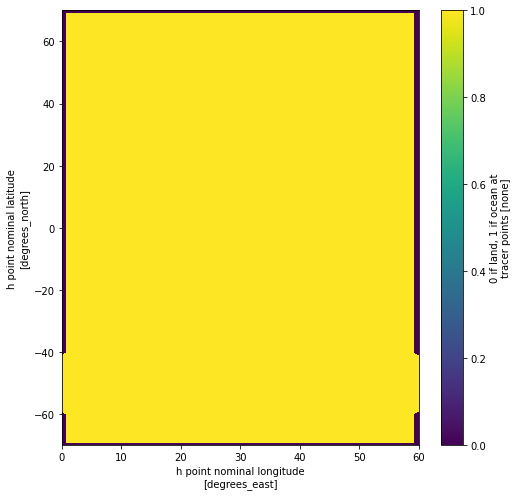

In [6]:
ds_static.wet.plot(figsize=(8,8))

## Preparing the grid info 

These are the grid variables that our vector Laplacian needs to know.

In [7]:
gcm_filters.required_grid_vars(gcm_filters.GridType.VECTOR_C_GRID)

['wet_mask_t',
 'wet_mask_q',
 'dxT',
 'dyT',
 'dxCu',
 'dyCu',
 'dxCv',
 'dyCv',
 'dxBu',
 'dyBu',
 'area_u',
 'area_v',
 'kappa_iso',
 'kappa_aniso']

`dxT`, `dyT`, `dxBu`, and `dyBu` are grid lengths centered at T-points and vorticity points respectively. `ds_static` doesn't hold these grid variables, but we can compute them easily thanks to the [xgcm package](https://xgcm.readthedocs.io/en/latest/grids.html).

In [8]:
from xgcm import Grid
coords = {'X': {'center': 'xh', 'outer': 'xq'},
            'Y': {'center': 'yh', 'outer': 'yq'}
         }
grid = Grid(ds_static, coords=coords, periodic=['X']) # NeverWorld2 has a periodic ACC-like channel in x-direction

ds_static['dxT'] = grid.interp(ds_static.dxCu,'X')
ds_static['dyT'] = grid.interp(ds_static.dyCv,'Y')
ds_static['dxBu'] = grid.interp(ds_static.dxCv,'X')
ds_static['dyBu'] = grid.interp(ds_static.dyCu,'Y',boundary='fill')

Neverworld2's grid spacing is constant in y-direction, and varies in x-direction.

[Text(0.5, 1.0, 'y-spacing'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

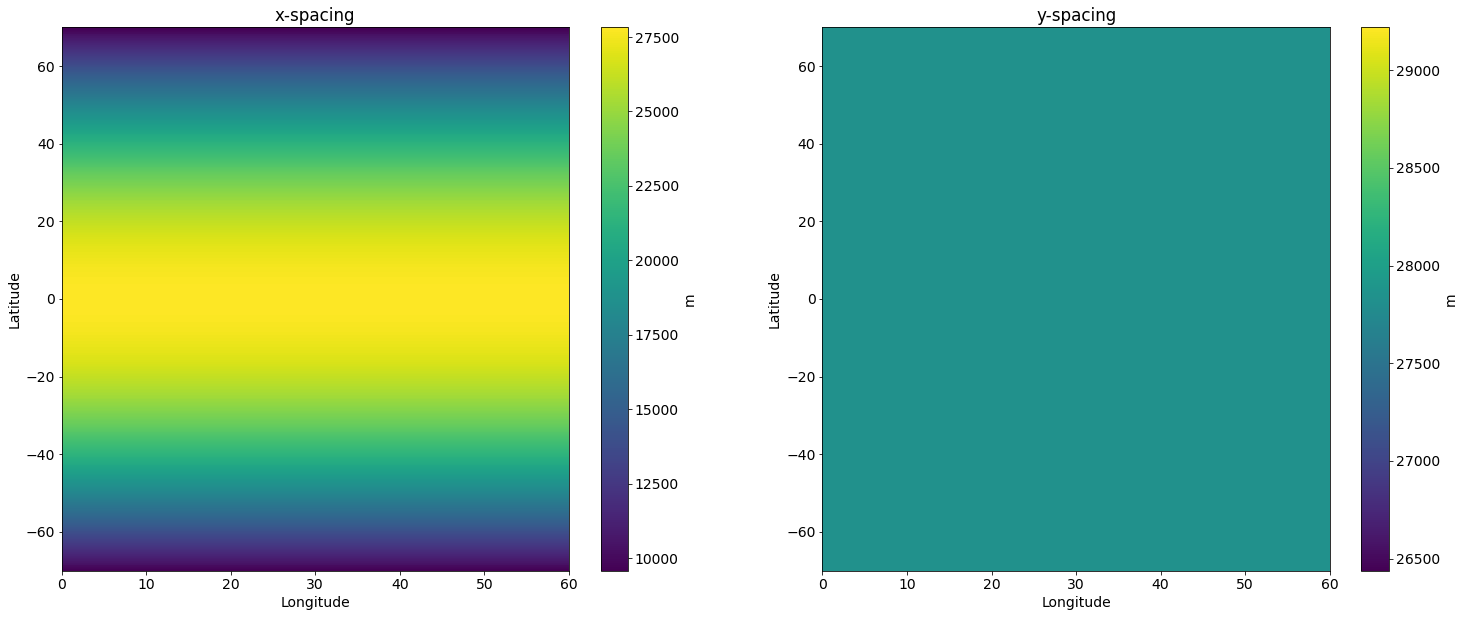

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'font.size': 14}
pylab.rcParams.update(params)

fig,axs = plt.subplots(1,2,figsize=(25,10))
ds_static.dxT.plot(ax=axs[0], cbar_kwargs={'label': 'm'})
axs[0].set(title='x-spacing', xlabel='Longitude', ylabel='Latitude')
ds_static.dyT.plot(ax=axs[1], cbar_kwargs={'label': 'm'})
axs[1].set(title='y-spacing', xlabel='Longitude', ylabel='Latitude')

We are now ready to define all grid input variables for our vector Laplacian.

In [10]:
# grid info centered at T-points
wet_mask_t = ds_static.wet
dxT = ds_static.dxT
dyT = ds_static.dyT
# grid info centered at U-points
dxCu = xr.DataArray(ds_static.dxCu.isel(xq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
dyCu = xr.DataArray(ds_static.dyCu.isel(xq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
area_u = xr.DataArray(ds_static.area_u.isel(xq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
# grid info centered at V-points
dxCv = xr.DataArray(ds_static.dxCv.isel(yq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
dyCv = xr.DataArray(ds_static.dyCv.isel(yq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
area_v = xr.DataArray(ds_static.area_v.isel(yq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
# grid info centered at vorticity points
wet_mask_q = xr.DataArray(ds_static.wet_c.isel(xq=slice(1,None), yq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
dxBu = xr.DataArray(ds_static.dxBu.isel(xq=slice(1,None), yq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))
dyBu = xr.DataArray(ds_static.dyBu.isel(xq=slice(1,None), yq=slice(1,None)), coords={'yh':ds.yh,'xh':ds.xh}, dims=('yh','xh'))

In the above cell, we
1. removed the padding in the `xq` and `yq` dimensions (on the lower side) and 
2. renamed the `xq` and `yq` dimensions so that all grid variables have the same dimensions: `xh`, `yh`. 

This is because, as of now, `gcm-filters` requires all input variables to have the same dimensions, even though the grid variables are assumed staggered. (This is something we would like to change in the future.)

Next, we compute the minimum and maximum grid spacing.

In [11]:
dx_min = min(dxT.min(), dyT.min(), dxCu.min(), dyCu.min(), dxCv.min(), dyCv.min(), dxBu.min(), dyBu.min())
dx_min = dx_min.values
dx_min

array(9518.17259783)

In [12]:
dx_max = max(dxT.max(), dyT.max(), dxCu.max(), dyCu.max(), dxCv.max(), dyCv.max(), dxBu.max(), dyBu.max())
dx_max = dx_max.values
dx_max

array(27829.27492305)

## Viscosity-based filtering with fixed length scale

First, we want to filter velocity with a **fixed filter length scale of 200 km**. That is, we use a filter that attempts to remove scales smaller than 200 km. 

In [13]:
filter_scale = 200000

Since we don't want to vary the filter scale spatially and we are happy with an isotropic filter, we set `kappa_iso` and `kappa_aniso` equal to 1 over the full domain.

In [14]:
kappa_iso = xr.ones_like(dxT)
kappa_aniso = xr.zeros_like(dyT)

We now create our filter.

In [15]:
filter_visc_200km = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={
        'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
        'dxT': dxT, 'dyT': dyT, 
        'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
        'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
        'dxBu': dxBu, 'dyBu': dyBu,
        'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
    }
)
filter_visc_200km

Filter(filter_scale=200000, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=24, grid_type=<GridType.VECTOR_C_GRID: 6>)

### Removing padding and swapping dimensions

Next, we prepare the vector field that we want to filter: $(u,v)$. Consistent with the two steps we performed for the grid variables above, we first remove the padding in the `xq` and `yq` dimensions on the lower side.

In [16]:
u = ds['u'].isel(xq=slice(1,None))
u

<xarray.DataArray 'u' (time: 100, zl: 15, yh: 560, xq: 240)>
dask.array<getitem, shape=(100, 15, 560, 240), dtype=float32, chunksize=(10, 15, 560, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xq       (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 59.0 59.25 59.5 59.75 60.0
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Attributes:
    cell_methods:   zl:mean yh:mean xq:point time: mean
    interp_method:  none
    long_name:      Zonal velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m s-1

In [17]:
v = ds['v'].isel(yq=slice(1,None))
v

<xarray.DataArray 'v' (time: 100, zl: 15, yq: 560, xh: 240)>
dask.array<getitem, shape=(100, 15, 560, 240), dtype=float32, chunksize=(10, 15, 560, 240), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq       (yq) float64 -69.75 -69.5 -69.25 -69.0 ... 69.25 69.5 69.75 70.0
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Attributes:
    cell_methods:   zl:mean yq:point xh:mean time: mean
    interp_method:  none
    long_name:      Meridional velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m s-1

Next, we have to rename the `xq` and `yq` dimensions to `xh` and `yh`, respectively. We make a temporary dataset `ds_tmp`, in which the `xh` and `xq` dimensions, as well as `yh` and `yq` dimensions, have the same length, respectively. (In contrast, in the original dataset `ds`, the `xq` dimension has one entry more than `xh`, and similarly for `yq` and `yh`.)

In [18]:
ds_tmp = xr.Dataset()  # temporary dataset with renamed dimensions
ds_tmp['u'] = u
ds_tmp['v'] = v
ds_tmp

<xarray.Dataset>
Dimensions:  (time: 100, xh: 240, xq: 240, yh: 560, yq: 560, zl: 15)
Coordinates:
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xq       (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 59.0 59.25 59.5 59.75 60.0
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * yq       (yq) float64 -69.75 -69.5 -69.25 -69.0 ... 69.25 69.5 69.75 70.0
Data variables:
    u        (time, zl, yh, xq) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>
    v        (time, zl, yq, xh) float32 dask.array<chunksize=(10, 15, 560, 240), meta=np.ndarray>

With `ds_tmp.xh` and `ds_tmp.xq` being of the same length, we can now swap dimensions for `ds_tmp.u`. (And similar for `ds_tmp.v`.)

In [19]:
ds_tmp['u'] = ds_tmp['u'].swap_dims({'xq':'xh'})
ds_tmp['v'] = ds_tmp['v'].swap_dims({'yq':'yh'})

`ds_tmp.u` and `ds_tmp.v` have now the dimensions that our filter can work with. 

In [20]:
ds_tmp.u

<xarray.DataArray 'u' (time: 100, zl: 15, yh: 560, xh: 240)>
dask.array<getitem, shape=(100, 15, 560, 240), dtype=float32, chunksize=(10, 15, 560, 240), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Attributes:
    cell_methods:   zl:mean yh:mean xq:point time: mean
    interp_method:  none
    long_name:      Zonal velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m s-1

In [21]:
ds_tmp.v

<xarray.DataArray 'v' (time: 100, zl: 15, yh: 560, xh: 240)>
dask.array<getitem, shape=(100, 15, 560, 240), dtype=float32, chunksize=(10, 15, 560, 240), chunktype=numpy.ndarray>
Coordinates:
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Attributes:
    cell_methods:   zl:mean yq:point xh:mean time: mean
    interp_method:  none
    long_name:      Meridional velocity
    time_avg_info:  average_T1,average_T2,average_DT
    units:          m s-1

Below, we will only be interested in plotting the filtered velocity data from a single time slice and a single layer. We can therefore make things more efficient if we first rechunk our Dask array in such a way that each chunk contains only a 2D field.

In [22]:
ds_tmp = ds_tmp.chunk({'time': 1, 'zl': 1})
ds_tmp.u

,Array,Chunk
Bytes,806.40 MB,537.60 kB
Shape,"(100, 15, 560, 240)","(1, 1, 560, 240)"
Count,3021 Tasks,1500 Chunks
Type,float32,numpy.ndarray


### The filtered vector field

We now filter our velocity vector field lazily. In contrast to the diffusion-based filters, the viscosity-based filter **takes a vector field** (here: $(u,v)$) **as input** and **returns a vector field**. 

In [23]:
(u_filtered_200km, v_filtered_200km) = filter_visc_200km.apply_to_vector(ds_tmp['u'], ds_tmp['v'], dims=['yh', 'xh'])

Next, we plot the unfiltered versus filtered velocity fields.

/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:368: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_u = np.where(self.area_u > 0, 1 / self.area_u, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:369: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_v = np.where(self.area_v > 0, 1 / self.area_v, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:368: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_u = np.where(self.area_u > 0, 1 / self.area_u, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:369: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_v = np.where(self.area_v > 0, 1 / self.area_v, 0)


[Text(0.5, 1.0, 'v filtered to 200 km'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

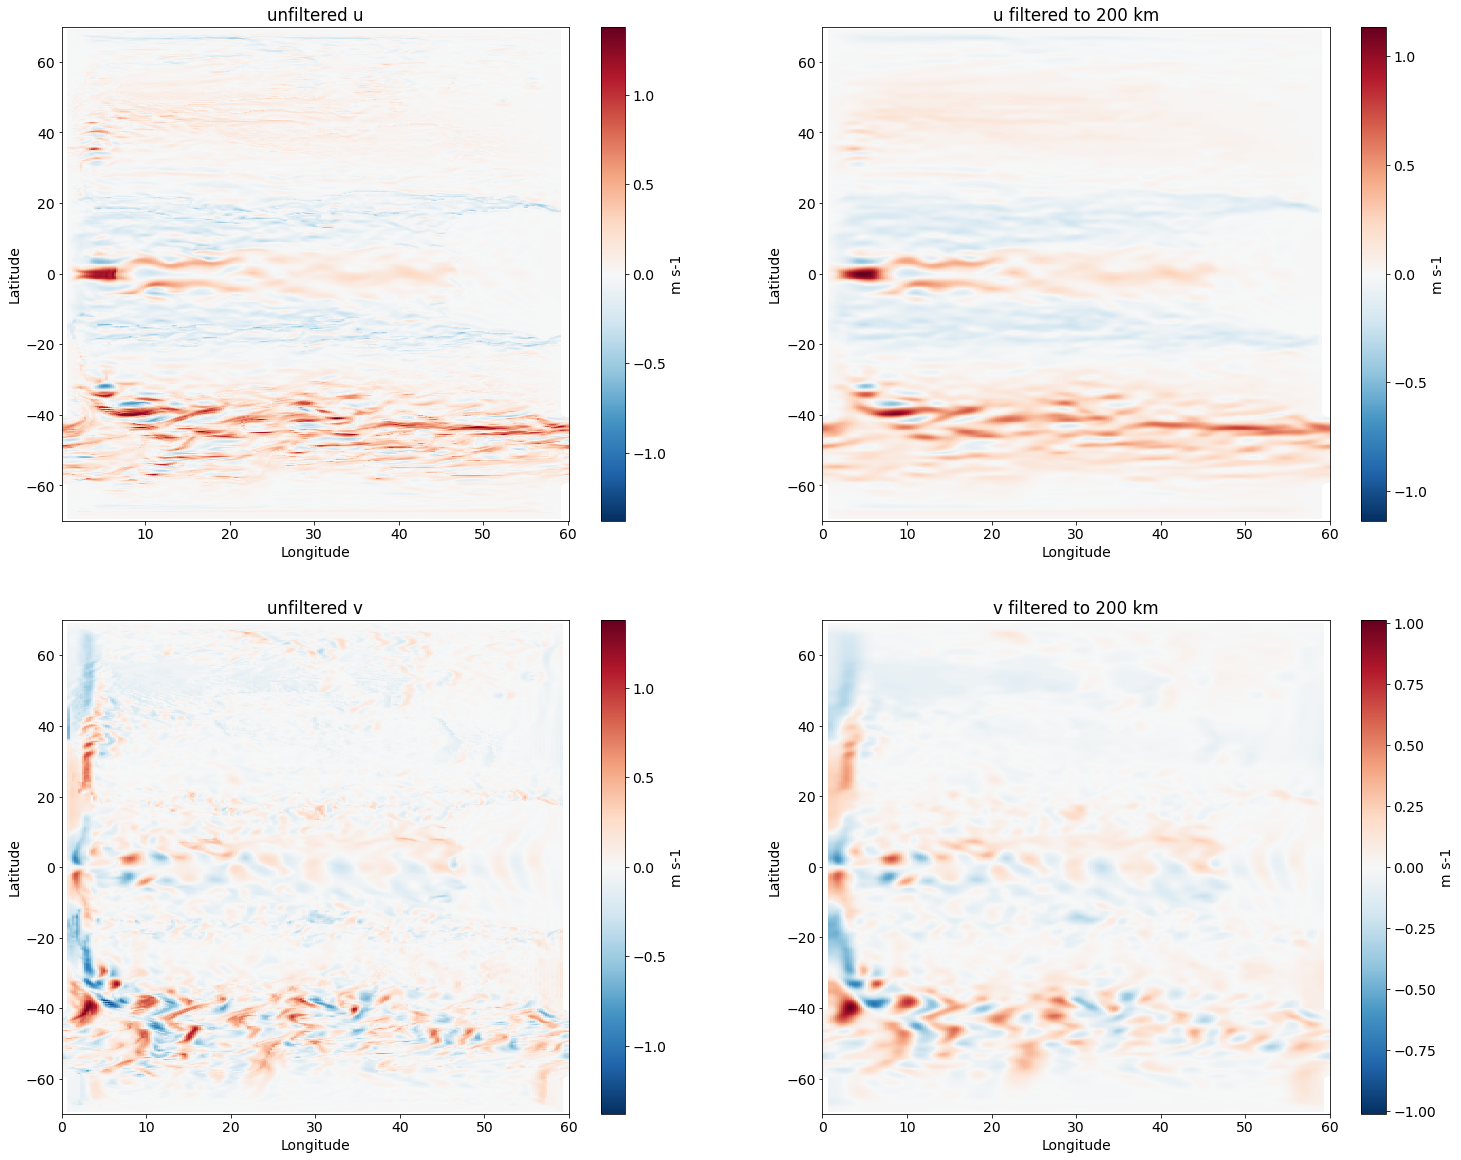

In [24]:
layer = 0
time = 50

fig,axs = plt.subplots(2,2,figsize=(25,20))
u.isel(time=time, zl=layer).plot(ax=axs[0,0], cbar_kwargs={'label': 'm s-1'})
axs[0,0].set(title='unfiltered u', xlabel='Longitude', ylabel='Latitude')
u_filtered_200km.isel(time=time, zl=layer).plot(ax=axs[0,1], cbar_kwargs={'label': 'm s-1'})
axs[0,1].set(title='u filtered to 200 km', xlabel='Longitude', ylabel='Latitude')

v.isel(time=time, zl=layer).plot(ax=axs[1,0], cbar_kwargs={'label': 'm s-1'})
axs[1,0].set(title='unfiltered v', xlabel='Longitude', ylabel='Latitude')
v_filtered_200km.isel(time=time, zl=layer).plot(ax=axs[1,1], cbar_kwargs={'label': 'm s-1'})
axs[1,1].set(title='v filtered to 200 km', xlabel='Longitude', ylabel='Latitude')

### Swapping back the dimensions and re-adding the padding

Our filtered velocities still have the assigned dimensions `xh` and `yh`, even though they live on the staggered C-grid (as the original velocities).

In [25]:
u_filtered_200km

,Array,Chunk
Bytes,806.40 MB,537.60 kB
Shape,"(100, 15, 560, 240)","(1, 1, 560, 240)"
Count,10565 Tasks,1500 Chunks
Type,float32,numpy.ndarray


For further analysis of the filtered velocities, it may be useful to give the velocities back its proper dimensions. That's what is happening in the remainder of this subsection. 

In [26]:
ds_tmp['u_filtered'] = u_filtered_200km
ds_tmp['v_filtered'] = v_filtered_200km
ds_tmp['u_filtered'] = ds_tmp['u_filtered'].swap_dims({'xh':'xq'})
ds_tmp['v_filtered'] = ds_tmp['v_filtered'].swap_dims({'yh':'yq'})
ds_tmp.u_filtered

,Array,Chunk
Bytes,806.40 MB,537.60 kB
Shape,"(100, 15, 560, 240)","(1, 1, 560, 240)"
Count,10565 Tasks,1500 Chunks
Type,float32,numpy.ndarray


`ds_tmp.u_filtered` has now the right dimensions, but the `xq` dimension is missing its first entry. Indeed, compare the values of `ds_tmp.u_filtered.xq` with the original `ds.u.xq`.

In [27]:
ds_tmp.u_filtered.xq

<xarray.DataArray 'xq' (xq: 240)>
array([ 0.25,  0.5 ,  0.75, ..., 59.5 , 59.75, 60.  ])
Coordinates:
  * xq       (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 59.0 59.25 59.5 59.75 60.0

In [28]:
ds.u.xq

<xarray.DataArray 'xq' (xq: 241)>
array([ 0.  ,  0.25,  0.5 , ..., 59.5 , 59.75, 60.  ])
Coordinates:
  * xq       (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.0 59.25 59.5 59.75 60.0
Attributes:
    cartesian_axis:  X
    long_name:       q point nominal longitude
    units:           degrees_east

The first entry of `ds_tmp.u_filtered.xq` is missing because we removed that padding before filtering (in step 1). To reverse step 1 from above, we define a new dataset for the filtered fields and assign this new dataset the dimensions from the original dataset `ds`.

In [29]:
ds_filtered = xr.Dataset() # new xarray dataset for viscosity-based filtered fields
for dim in ds.dims:
    ds_filtered[dim] = ds[dim]

In [30]:
ds_filtered

<xarray.Dataset>
Dimensions:  (nv: 2, time: 100, xh: 240, xq: 241, yh: 560, yq: 561, zi: 16, zl: 15)
Coordinates:
  * nv       (nv) float64 1.0 2.0
  * time     (time) object 0084-05-03 12:00:00 ... 0085-09-18 12:00:00
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 59.12 59.38 59.62 59.88
  * xq       (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.0 59.25 59.5 59.75 60.0
  * yh       (yh) float64 -69.88 -69.62 -69.38 -69.12 ... 69.38 69.62 69.88
  * yq       (yq) float64 -70.0 -69.75 -69.5 -69.25 ... 69.25 69.5 69.75 70.0
  * zi       (zi) float64 1.022e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
  * zl       (zl) float64 1.023e+03 1.023e+03 1.023e+03 ... 1.028e+03 1.028e+03
Data variables:
    *empty*

Now we can re-add the padding for the filtered fields in the `xq` and `yq` dimensions.

In [31]:
import dask
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ds_filtered['u'] = ds_tmp['u_filtered']
    ds_filtered['v'] = ds_tmp['v_filtered']
# first and last xq slice are the same due to peridocity in x
ds_filtered['u'] = xr.where(ds.xq==ds.xq[0], ds_filtered['u'].roll(xq=1,roll_coords=False), ds_filtered['u'])
# set yq = 0 to nan's (this is all land):
ds_filtered['v'] = xr.where(ds.yq==ds.yq[0], np.nan, ds_filtered['v'])

/glade/work/noraloose/my_npl_clone_20201220/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,
/glade/work/noraloose/my_npl_clone_20201220/lib/python3.7/site-packages/dask/array/core.py:4150: PerformanceWarning: Increasing number of chunks by factor of 15
  **blockwise_kwargs,


In [32]:
ds_filtered.u.xq

<xarray.DataArray 'xq' (xq: 241)>
array([ 0.  ,  0.25,  0.5 , ..., 59.5 , 59.75, 60.  ])
Coordinates:
  * xq       (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 59.0 59.25 59.5 59.75 60.0

Since `ds.u` and `ds_filtered.u` now have the same dimensions (as they should), we can go ahead and plot the difference in unfiltered and filtered fields. That is, we plot the differences between the first and second column from the previous plot.

/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:368: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_u = np.where(self.area_u > 0, 1 / self.area_u, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:369: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_v = np.where(self.area_v > 0, 1 / self.area_v, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:368: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_u = np.where(self.area_u > 0, 1 / self.area_u, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:369: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_v = np.where(self.area_v > 0, 1 / self.area_v, 0)


[Text(0.5, 1.0, '(unfiltered - filtered) v'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

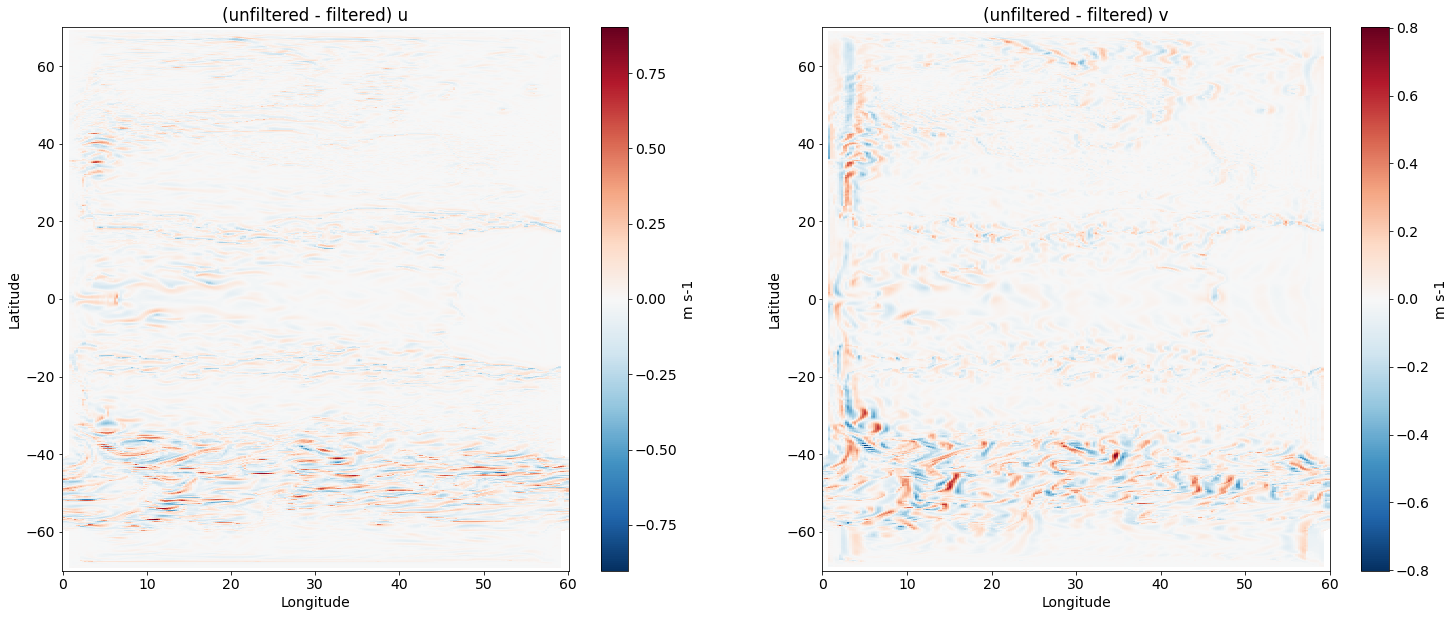

In [33]:
fig,axs = plt.subplots(1,2,figsize=(25,10))
(ds.u - ds_filtered.u).isel(time=time, zl=layer).plot(ax=axs[0], cbar_kwargs={'label': 'm s-1'})
axs[0].set(title='(unfiltered - filtered) u', xlabel='Longitude', ylabel='Latitude')
(ds.v - ds_filtered.v).isel(time=time, zl=layer).plot(ax=axs[1], cbar_kwargs={'label': 'm s-1'})
axs[1].set(title='(unfiltered - filtered) v', xlabel='Longitude', ylabel='Latitude')

## Viscosity-based filtering with fixed filter factor

In our second example, we want to filter velocity with a **fixed filter factor of 10**. That is, our goal is to use a filter that removes scales smaller than **10 times the local grid scale**. 
The fixed factor filter is a **spatially-varying & anisotropic filter**. Consistent with the MOM6 implementation of anisotropic viscosity, the conventions for the `VECTOR_C_GRID` Laplacian are:
* `kappa_iso` is the isotropic viscosity,
* `kappa_aniso` is the additive anisotropy that is aligned with x-direction,

resulting in `kappa_x = kappa_iso` and `kappa_y = kappa_iso + kappa_aniso`. Anisotropy in an arbitrary direction (not aligned with the grid directions) is not yet implemented for `VECTOR_C_GRID`, but could be added mimicking the implementation in MOM6 (following [Smith and McWilliams, 2003](https://www.sciencedirect.com/science/article/pii/S1463500302000161?via%3Dihub)). 

These are the filter specs for the viscosity-based fixed factor filter (similar as for the diffusion-based *fixed factor* filter in [this tutorial](https://gcm-filters.readthedocs.io/en/latest/tutorial_filter_types.html)). 

In [34]:
filter_scale = 10 * dx_max
kappa_iso = dyCv * dyCv / (dx_max * dx_max)
kappa_aniso = dxCu*dxCu / (dx_max * dx_max) - dyCv * dyCv / (dx_max * dx_max)

The filter needs: $0 < \kappa_{iso} \leq 1$ and $0 < \kappa_{iso} + \kappa_{aniso} \leq 1$. These requirements are satisfied as shown in the next plot.

[Text(0.5, 1.0, 'kappa_iso + kappa_aniso'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

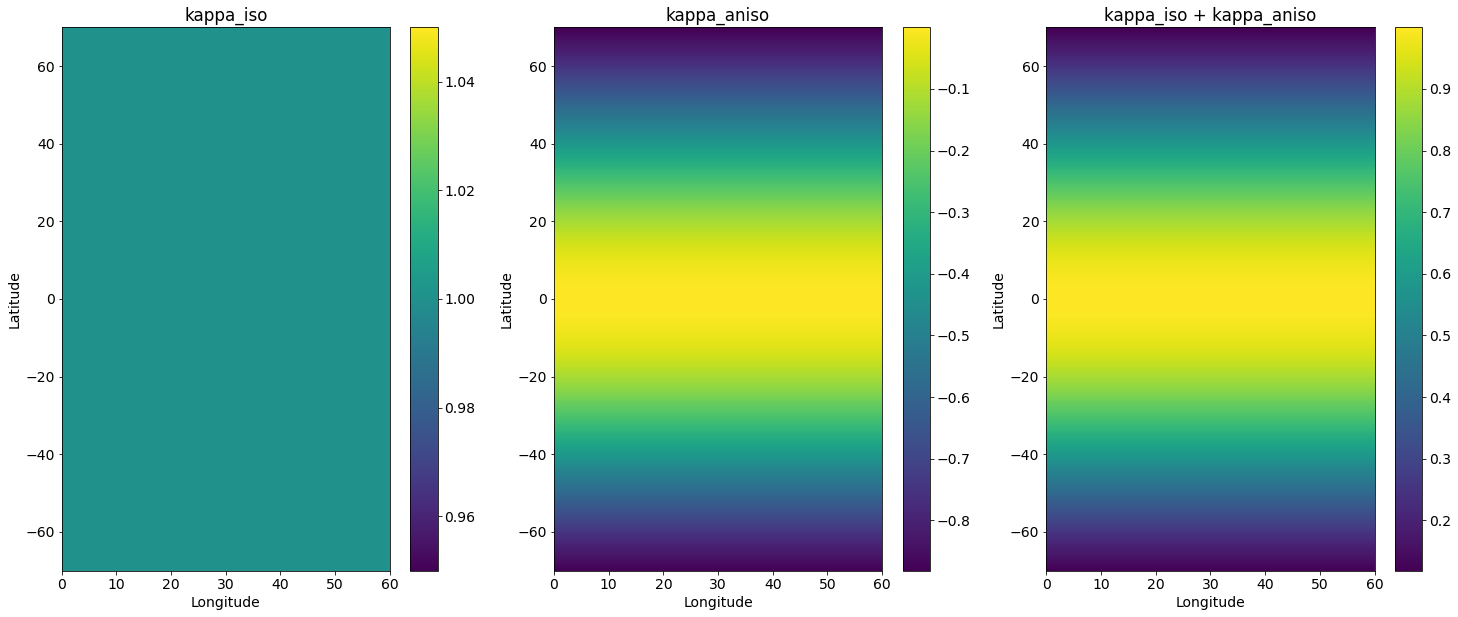

In [35]:
fig,axs = plt.subplots(1,3,figsize=(25,10))
kappa_iso.plot(ax=axs[0], cbar_kwargs={'label': ''})
axs[0].set(title='kappa_iso', xlabel='Longitude', ylabel='Latitude')
kappa_aniso.plot(ax=axs[1], cbar_kwargs={'label': ''})
axs[1].set(title='kappa_aniso', xlabel='Longitude', ylabel='Latitude')
(kappa_iso + kappa_aniso).plot(ax=axs[2], cbar_kwargs={'label': ''})
axs[2].set(title='kappa_iso + kappa_aniso', xlabel='Longitude', ylabel='Latitude')

We now create our fixed factor filter.

In [36]:
filter_fac10 = gcm_filters.Filter(
    filter_scale=filter_scale,
    dx_min=dx_min,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.VECTOR_C_GRID,
    grid_vars={'wet_mask_t': wet_mask_t, 'wet_mask_q': wet_mask_q,
                'dxT': dxT, 'dyT': dyT, 
               'dxCu': dxCu, 'dyCu': dyCu, 'area_u': area_u, 
               'dxCv': dxCv, 'dyCv': dyCv, 'area_v': area_v,
               'dxBu': dxBu, 'dyBu': dyBu,
               'kappa_iso': kappa_iso, 'kappa_aniso': kappa_aniso
              }
)
filter_fac10

Filter(filter_scale=278292.7492304958, dx_min=array(9518.17259783), filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=33, grid_type=<GridType.VECTOR_C_GRID: 6>)

In [37]:
(u_filtered_fac10, v_filtered_fac10) = filter_fac10.apply_to_vector(ds_tmp['u'], ds_tmp['v'], dims=['yh', 'xh'])

/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:368: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_u = np.where(self.area_u > 0, 1 / self.area_u, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:369: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_v = np.where(self.area_v > 0, 1 / self.area_v, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:368: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_u = np.where(self.area_u > 0, 1 / self.area_u, 0)
/glade/u/home/noraloose/gcm-filters/gcm_filters/kernels.py:369: RuntimeWarning: divide by zero encountered in true_divide
  self.recip_area_v = np.where(self.area_v > 0, 1 / self.area_v, 0)


[Text(0.5, 1.0, 'v filtered by factor 10'),
 Text(0.5, 0, 'Longitude'),
 Text(0, 0.5, 'Latitude')]

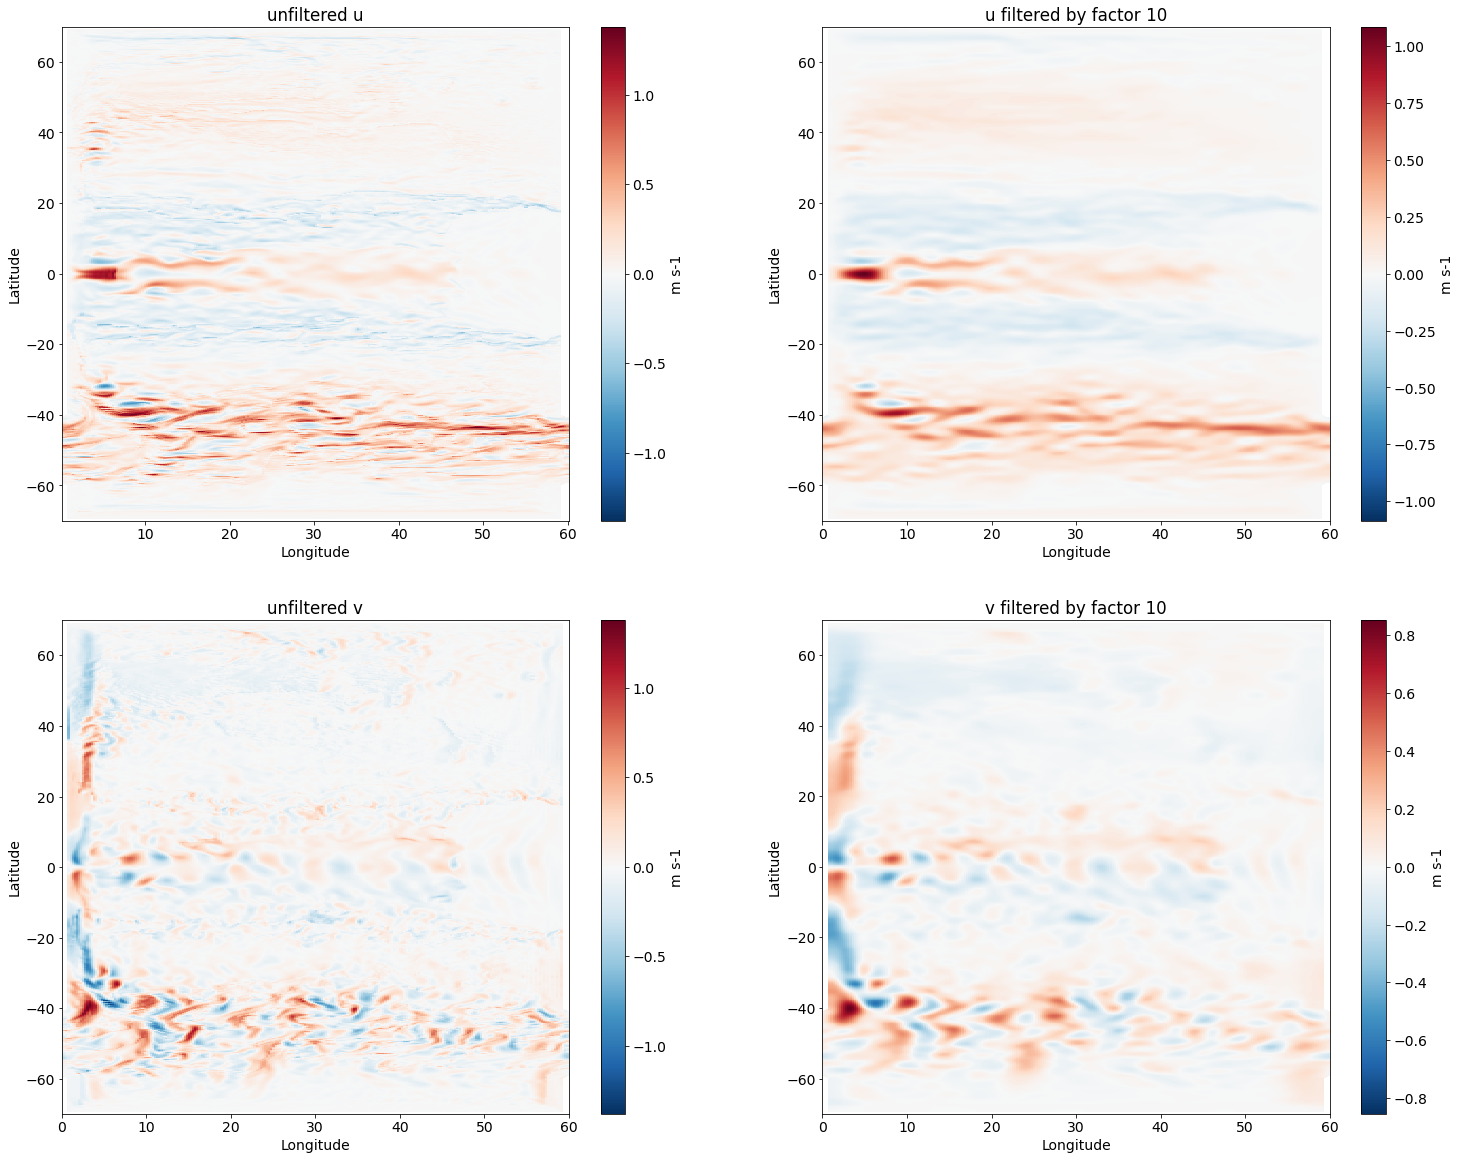

In [38]:
fig,axs = plt.subplots(2,2,figsize=(25,20))
u.isel(time=time, zl=layer).plot(ax=axs[0,0], cbar_kwargs={'label': 'm s-1'})
axs[0,0].set(title='unfiltered u', xlabel='Longitude', ylabel='Latitude')
u_filtered_fac10.isel(time=time, zl=layer).plot(ax=axs[0,1], cbar_kwargs={'label': 'm s-1'})
axs[0,1].set(title='u filtered by factor 10', xlabel='Longitude', ylabel='Latitude')

v.isel(time=time, zl=layer).plot(ax=axs[1,0], cbar_kwargs={'label': 'm s-1'})
axs[1,0].set(title='unfiltered v', xlabel='Longitude', ylabel='Latitude')
v_filtered_fac10.isel(time=time, zl=layer).plot(ax=axs[1,1], cbar_kwargs={'label': 'm s-1'})
axs[1,1].set(title='v filtered by factor 10', xlabel='Longitude', ylabel='Latitude')